## Hw2 Matching

In [1]:
from __future__ import division, print_function
import glob
import os
import warnings
warnings.simplefilter("ignore")
import cv2
import PIL
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from config_profile import args
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from Utils import L2Norm, cv2_scale, np_reshape
from scipy.optimize import linear_sum_assignment
import re
%matplotlib inline

### Check GPU availability, using nvidia-smi 

In [2]:
# Since there are two GPUs on each pelican server, you can either select it as 0 or 1
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(torch.__version__)
print(torch.version.cuda)  
print(torch.cuda.is_available())

1.8.1+cu101
10.1
True


Get patches function

In [3]:
def getPatches(kps, img, size=32, num=20):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) 
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) 
        
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)

        cropped_img = img[ymin: ymax, xmin: xmax]
        ch, cw = cropped_img.shape
        res[i, 0, ymin_res: ymin_res+ch, xmin_res: xmin_res+cw] =  cropped_img
        
    return res

### Find the keypoints from query images and dataset images

In [61]:
all_patches = []


img_dir = "query"  # query, images
if os.path.exists(img_dir):
    if os.listdir(img_dir) is []:
        print("No images!")
        exit(0)
        
    sorted_listdir = sorted(os.listdir(img_dir), key=lambda e: [int(s) for s in re.split('[q.]', e) if s.isdigit()])
    num_img = len(os.listdir(img_dir))
    for img in sorted_listdir:
        if not img.endswith("JPG"):
            continue
        
        image_dir = os.path.join(img_dir, img)
        image = cv2.imread(image_dir)
        gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
        print(image_dir)
        
        #SIFT Detector
        sift = cv2.SIFT_create(nfeatures = 20)
        kp, des = sift.detectAndCompute(gray,None)
        keypoints = []
        
        for i in range(len(kp)):
            keypoints.append([kp[i].pt[0],kp[i].pt[1]])
        
        patches = getPatches(keypoints, gray, size=32, num=20)
        all_patches.append(patches)
          
    
        
#         for patch in patches:
#             image = patch[0].numpy()
#             plt.imshow(image, cmap='gray')
#             plt.show()
            
    print('all_patch:',len(all_patches)) 

else:
    print("image folder not exists!")
    exit(0)


query/q1.JPG
query/q2.JPG
query/q3.JPG
query/q4.JPG
query/q5.JPG
query/q6.JPG
query/q7.JPG
query/q8.JPG
query/q9.JPG
query/q10.JPG
query/q11.JPG
query/q12.JPG
query/q13.JPG
query/q14.JPG
query/q15.JPG
query/q16.JPG
query/q17.JPG
query/q18.JPG
query/q19.JPG
query/q20.JPG
query/q21.JPG
query/q22.JPG
query/q23.JPG
query/q24.JPG
query/q25.JPG
query/q26.JPG
query/q27.JPG
query/q28.JPG
query/q29.JPG
query/q30.JPG
query/q31.JPG
query/q32.JPG
query/q33.JPG
query/q34.JPG
all_patch: 34


In [62]:
all_patches = torch.stack(all_patches, dim=0)
output_dir = "query_patches.pth"         # modify it to images_patches.pth or query_patches.pth
torch.save(all_patches, output_dir)

In [63]:
test_patches = torch.load(output_dir)
print(type(test_patches))
print(test_patches.shape)

print(test_patches[0])
print(test_patches[1])
# your tensor for each should have size of [136, 200, 1, 32, 32];where 136 means 136 images (in the order 1-10), 20 means 20 points.(images)
# your tensor for each should have size of [34, 200, 1, 32, 32];where 34 means 34 images (in the order 1-10), 20 means 20 points.(query)

<class 'torch.Tensor'>
torch.Size([34, 20, 1, 32, 32])
tensor([[[[174., 173., 176.,  ..., 174., 175.,  73.],
          [175., 174., 177.,  ..., 184., 166.,  70.],
          [168., 177., 177.,  ..., 168., 156., 108.],
          ...,
          [188., 192., 194.,  ..., 177., 196., 208.],
          [183., 191., 195.,  ..., 189., 196., 202.],
          [184., 194., 199.,  ..., 200., 198., 198.]]],


        [[[168., 135.,  75.,  ..., 129., 140.,  96.],
          [163., 116.,  50.,  ...,  52.,  75.,  72.],
          [170., 159., 155.,  ..., 109., 124., 129.],
          ...,
          [174., 165.,  71.,  ..., 157., 178., 154.],
          [179., 170.,  94.,  ..., 190., 176., 119.],
          [172., 179., 135.,  ..., 180., 188., 160.]]],


        [[[168., 135.,  75.,  ..., 129., 140.,  96.],
          [163., 116.,  50.,  ...,  52.,  75.,  72.],
          [170., 159., 155.,  ..., 109., 124., 129.],
          ...,
          [174., 165.,  71.,  ..., 157., 178., 154.],
          [179., 170.,  94.,

### Load network weights

In [91]:
from my_CNN2 import DesNet #our or my CNN.py
model = DesNet()

if args.cuda:
    model.cuda()

trained_weight_path = "models/my_checkpoint2.pth" # suppose you select *checkpoint.pth as the best model for this architecture
test_model = DesNet()
if args.cuda:
    test_model.cuda()
trained_weight = torch.load(trained_weight_path)['state_dict']
test_model.load_state_dict(trained_weight)
test_model.eval()

DesNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(128, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (9): ReLU()
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv2d(128, 128, kernel_size=(8, 8), stride=(1, 1), bias=F

### Load raw patch files

In [95]:
patches_dir = "query_patches.pth"            # these patches are from keypoint detection results e.g. images_patches.pth or query_patches.pth
#patches_dir = "images_patches.pth"  
patches = torch.load(patches_dir)
print(patches.shape)                  # in your case, the shape should be [10, 200, 1, 32, 32]
num_imgs, num_pts, _, _, _ = patches.shape
patches = patches.view(-1, 1, 32, 32).cuda()
print(patches.shape)


torch.Size([34, 20, 1, 32, 32])
torch.Size([680, 1, 32, 32])


### Get deep features

In [96]:
features = test_model(patches)
print(features.shape)
features = features.view(num_imgs, num_pts, 128).cpu().data
print(features.shape)                  # in your case, the shape should be [10, 200, 128]

torch.Size([680, 128])
torch.Size([34, 20, 128])


In [97]:
# save to file, with the name of images or query_features.pth
features_dir = "query_features_my_CNN.pth" #query_features_our_CNN.pth, query_features_my_CNN.pth, images_features_our_CNN.pth, images_features_my_CNN.pth
torch.save(features, features_dir)

In [3]:
#combine features
q_mycnn = torch.load("query_features_my_CNN.pth")
i_mycnn = torch.load("images_features_my_CNN.pth")
features1 = torch.cat((q_mycnn, i_mycnn), dim = 0)
torch.save(features1, "features1.pth")
print('q_mycnn :', q_mycnn.shape)
print('i_mycnn :', i_mycnn.shape)
print('features1 :', features1.shape)

q_ourcnn = torch.load("query_features_our_CNN.pth")

i_ourcnn = torch.load("images_features_our_CNN.pth")
features2 = torch.cat((q_ourcnn, i_ourcnn), dim = 0)
torch.save(features2, "features2.pth")
print('q_ourcnn :', q_ourcnn.shape)
print('i_ourcnn :', i_ourcnn.shape)
print('features2 :', features2.shape)


q_mycnn : torch.Size([34, 20, 128])
i_mycnn : torch.Size([136, 20, 128])
features1 : torch.Size([170, 20, 128])
q_ourcnn : torch.Size([34, 20, 128])
i_ourcnn : torch.Size([136, 20, 128])
features2 : torch.Size([170, 20, 128])


### Get similarity matrices

In [3]:
f_query = torch.load("query_features_my_CNN.pth") #query_features_our_CNN.pth, query_features_my_CNN.pth
f_images = torch.load("images_features_my_CNN.pth") #images_features_our_CNN.pth, images_features_my_CNN.pth

print('f_query :', f_query.shape)
print('f_images :', f_images.shape)


f_q = f_query[0]
f_i = f_images[0]
simi = torch.zeros(20, 20)
#cost = torch.zeros(20, 20)
print(f_q.shape)
print(f_i.shape)
for i in range(20):
    for j in range(20):
        simi[i,j] = (1 + F.cosine_similarity(f_q[i], f_i[j], dim=0))/2
        cost = 1 - simi
        row_ind, col_ind = linear_sum_assignment(cost.cpu().numpy())
# print(cost)
# print(row_ind)
# print(col_ind)
print(simi[row_ind, col_ind].sum())

f_query : torch.Size([34, 20, 128])
f_images : torch.Size([136, 20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
tensor(17.6792)


In [111]:
def one2one_cost(f_q, f_i):
    cost = torch.zeros(20, 20)
    simi = torch.zeros(20, 20)
    for i in range(20):
        for j in range(20):
            simi[i,j] = (1 + F.cosine_similarity(f_q[i], f_i[j], dim=0))/2
            cost[i,j] = 1 - simi[i,j]
            row_ind, col_ind = linear_sum_assignment(cost.cpu().numpy())
    
    return simi[row_ind, col_ind].sum()

def many2many_cost(f_q, f_i, threshold= 0.002):
    simi = torch.zeros(20, 20)
    for i in range(20):
        for j in range(20):
            simi[i,j] = (1 + F.cosine_similarity(f_q[i], f_i[j], dim=0))/2
            
    simiNorm = torch.sqrt(torch.sum(simi * simi))
    simi_w = simi / simiNorm
    simi_w = simi_w.gt(threshold).float()
    
    return (simi*simi_w).sum()
            

In [112]:
num_query = 34
num_images = 136

one2one = torch.zeros(num_query, num_images)
many2many = torch.zeros(num_query, num_images)

for i in range(num_query):
    print("finished No.{} query".format(i+1))
    for j in range(num_images):
        one2one[i, j] = one2one_cost(f_query[i], f_images[j])
        many2many[i, j] = many2many_cost(f_query[i], f_images[j])
        

finished No.1 query
finished No.2 query
finished No.3 query
finished No.4 query
finished No.5 query
finished No.6 query
finished No.7 query
finished No.8 query
finished No.9 query
finished No.10 query
finished No.11 query
finished No.12 query
finished No.13 query
finished No.14 query
finished No.15 query
finished No.16 query
finished No.17 query
finished No.18 query
finished No.19 query
finished No.20 query
finished No.21 query
finished No.22 query
finished No.23 query
finished No.24 query
finished No.25 query
finished No.26 query
finished No.27 query
finished No.28 query
finished No.29 query
finished No.30 query
finished No.31 query
finished No.32 query
finished No.33 query
finished No.34 query


In [113]:
torch.save(one2one, "one2one_my_CNN.pth") # one2one_our_CNN.pth, one2one_my_CNN.pth
torch.save(many2many, "many2many_my_CNN.pth") # many2many_our_CNN.pth, many2many_my_CNN.pth

print(one2one.shape)
print(many2many.shape)

#print(one2one[0][2])

torch.Size([34, 136])
torch.Size([34, 136])


In [114]:
s = torch.load("many2many_my_CNN.pth")
print(s[0])

tensor([305.5307, 294.9021, 286.1891, 303.1107, 251.0905, 229.4309, 253.3837,
        224.2710, 202.3746, 233.8455, 238.8197, 247.5226, 276.6566, 246.7089,
        249.2020, 254.7012, 232.6393, 204.6151, 231.8051, 206.0430, 286.1118,
        284.7894, 291.1692, 295.4197, 233.8269, 240.7763, 203.2519, 226.8479,
        272.5327, 282.1113, 251.8949, 283.0021, 198.9613, 210.1407, 177.5143,
        185.4327, 270.9193, 248.9739, 265.1798, 214.5025, 284.7313, 289.2218,
        285.3844, 259.6801, 178.5487, 202.3270, 173.2561, 193.2098, 214.9453,
        195.8065, 169.9281, 196.6255, 207.1272, 180.9537, 193.3401, 211.2554,
        207.4528, 213.0452, 202.0715, 206.8229, 230.0147, 234.8837, 231.6817,
        214.4009, 242.9623, 244.7396, 241.1922, 254.6860, 236.2025, 197.9610,
        204.4934, 188.1815, 214.4266, 204.0286, 214.2450, 210.9882, 242.9501,
        210.5924, 203.0331, 214.1367, 177.4964, 171.1913, 180.2125, 176.2443,
        201.9164, 211.1945, 209.0051, 171.6597, 187.9238, 178.85

### Get top 4 one2one, many2many

In [9]:
our_one2one = torch.load("one2one_our_CNN.pth") # one2one_our_CNN.pth, one2one_my_CNN.pth
our_many2many = torch.load("many2many_our_CNN.pth") # many2many_our_CNN.pth, many2many_my_CNN.pth

my_one2one = torch.load("one2one_my_CNN.pth") # one2one_our_CNN.pth, one2one_my_CNN.pth
my_many2many = torch.load("many2many_my_CNN.pth") # many2many_our_CNN.pth, many2many_my_CNN.pth


### store retrieval.pth


# _, my_top4_one2one = torch.topk(my_one2one, 4, dim = 1)
# _, my_top4_many2many = torch.topk(my_many2many, 4, dim = 1)

# _, our_top4_one2one = torch.topk(our_one2one, 4, dim = 1)
# _, our_top4_many2many = torch.topk(our_many2many, 4, dim = 1)

# print('our_top4_one2one :', our_top4_one2one.shape)
# print('our_top4_many2many :', our_top4_many2many.shape)
# print('my_top4_one2one :', my_top4_one2one.shape)
# print('my_top4_many2many :', my_top4_many2many.shape)

#print(our_top4_one2one)

# retrieval = torch.stack([my_top4_many2many, my_top4_one2one, our_top4_many2many, our_top4_one2one], dim =0)
# torch.save(retrieva, "retrieval.pth")
# print(retrieval.shape)


# our_top4_one_index = torch.zeros(34, 4)   #first 4 means how many k in 34 query images, 34 means 34 query images, last 4 means 
# our_top4_many_index = torch.zeros(34, 4)

# my_top4_one_index = torch.zeros(34, 4)
# my_top4_many_index = torch.zeros(34, 4)

# for k in range(4):
#     _, our_top4_one   = torch.topk(our_one2one, k+1, dim = 1)
#     _, our_top4_many = torch.topk(our_many2many, k+1, dim = 1)
    
#     _, my_top4_one   = torch.topk(my_one2one, k+1, dim = 1)
#     _, my_top4_many = torch.topk(my_many2many, k+1, dim = 1)
    
#     our_top4_one_index[:, :k+1] = our_top4_one + 1
#     our_top4_many_index[:, :k+1] = our_top4_many + 1
    
#     my_top4_one_index[:, :k+1] = my_top4_one + 1
#     my_top4_many_index[:, :k+1] = my_top4_many + 1
    
# #print(my_top4_many)
# #print(my_top4_one_index)

# retrieval = torch.stack([my_top4_many_index, my_top4_one_index, our_top4_many_index, our_top4_one_index], dim =0)
# torch.save(retrieval, "retrieval.pth")
# print(retrieval.shape)

In [10]:
our_top4_one_index = torch.zeros(4, 34, 4)   #first 4 means how many k in 34 query images, 34 means 34 query images, last 4 means 
our_top4_many_index = torch.zeros(4, 34, 4)

my_top4_one_index = torch.zeros(4, 34, 4)
my_top4_many_index = torch.zeros(4, 34, 4)

for k in range(4):
    _, our_top4_one   = torch.topk(our_one2one, k+1, dim = 1)
    _, our_top4_many = torch.topk(our_many2many, k+1, dim = 1)
    
    our_top4_one_index[k, :, :k+1] = our_top4_one + 1
    our_top4_many_index[k, :, :k+1] = our_top4_many + 1

    
for i in range(4):
    _, my_top4_one   = torch.topk(my_one2one, i+1, dim = 1)
    _, my_top4_many = torch.topk(my_many2many, i+1, dim = 1)
    
    my_top4_one_index[i, :, :i+1] = my_top4_one + 1
    my_top4_many_index[i, :, :i+1] = my_top4_many + 1
#print(top4_one_index.shape)
#print(top4_many_index.shape)

#print(our_top4_one)
print(my_top4_one_index[3])
print(my_top4_many_index[3])

tensor([[  1.,  21.,   2.,  22.],
        [  5.,   7.,  56.,  66.],
        [110., 130., 109.,  87.],
        [ 23.,  21., 124.,   1.],
        [109.,  17., 108., 110.],
        [ 23.,  30., 124., 123.],
        [ 74.,  63.,  61.,  76.],
        [115.,  29.,  31.,  32.],
        [ 87.,  35.,  86., 110.],
        [ 99., 108., 110., 116.],
        [ 41.,  43.,  42.,  21.],
        [ 57., 104., 101.,  59.],
        [126., 117., 132.,  63.],
        [ 56.,  55.,  93.,  74.],
        [114.,  40.,  99., 115.],
        [ 61.,  62.,  64.,  63.],
        [ 67.,  65.,  68.,  44.],
        [104., 102.,  70.,  71.],
        [ 73.,  75.,  62.,  63.],
        [ 66., 132., 129.,  95.],
        [ 84., 134., 133.,  91.],
        [134., 136.,  91.,  45.],
        [ 89.,  74.,  73.,  63.],
        [ 76.,  73.,  75.,  74.],
        [ 98.,  29., 123.,   4.],
        [101., 102., 115.,  69.],
        [129.,  77.,  68.,  56.],
        [ 43.,  44.,  32.,  13.],
        [113., 114., 115.,  65.],
        [117.,

In [11]:
ground_truth = torch.empty(34, 4)

f = open('ground_truth.txt')
count = 0
for line in f.readlines():
    if not line.startswith("q"):
        continue
    line = line.strip().split("  ")
    query = int(line[0][1:])
    images = int(line[1])
    ground_truth[query - 1][count % 4] = images
    #print(query)
    count +=1
f.close
print(ground_truth)

tensor([[  1.,   2.,   3.,   4.],
        [  5.,   6.,   7.,   8.],
        [  9.,  10.,  11.,  12.],
        [ 13.,  14.,  15.,  16.],
        [ 17.,  18.,  19.,  20.],
        [ 21.,  22.,  23.,  24.],
        [ 25.,  26.,  27.,  28.],
        [ 29.,  30.,  31.,  32.],
        [ 33.,  34.,  35.,  36.],
        [ 37.,  38.,  39.,  40.],
        [ 41.,  42.,  43.,  44.],
        [ 45.,  46.,  47.,  48.],
        [ 49.,  50.,  51.,  52.],
        [ 53.,  54.,  55.,  56.],
        [ 57.,  58.,  59.,  60.],
        [ 61.,  62.,  63.,  64.],
        [ 65.,  66.,  67.,  68.],
        [ 69.,  70.,  71.,  72.],
        [ 73.,  74.,  75.,  76.],
        [ 77.,  78.,  79.,  80.],
        [ 81.,  82.,  83.,  84.],
        [ 85.,  86.,  87.,  88.],
        [ 89.,  90.,  91.,  92.],
        [ 93.,  94.,  95.,  96.],
        [ 97.,  98.,  99., 100.],
        [101., 102., 103., 104.],
        [105., 106., 107., 108.],
        [109., 110., 111., 112.],
        [113., 114., 115., 116.],
        [117.,

### Our_CNN

In [12]:
our_p_one = torch.zeros(4,1)
our_r_one = torch.zeros(4,1)

for k in range(4):
    precision_one, recall_one = 0, 0
    for i in range(34):
        for idx_images in our_top4_one_index[k][i][:k+1]:
            if int(idx_images) in ground_truth[i]:
                precision_one += 1/(k+1)/34
                recall_one += 1/4/34
    
    our_p_one[k] = precision_one
    our_r_one[k] = recall_one


our_p_many = torch.zeros(4,1)
our_r_many = torch.zeros(4,1)

for k in range(4):
    precision_many, recall_many = 0, 0
    for i in range(34):
        for idx_images in our_top4_many_index[k][i][:k+1]:
            if int(idx_images) in ground_truth[i]:
                precision_many += 1/(k+1)/34
                recall_many += 1/4/34
    
    our_p_many[k] = precision_many
    our_r_many[k] = recall_many
    
    
    
print('our_p_one :', our_p_one[:,0])
print('our_r_one :', our_r_one[:,0])
print('our_p_many :', our_p_many[:,0])
print('our_r_many :', our_r_many[:,0])
        

our_p_one : tensor([0.9706, 0.8824, 0.7549, 0.6765])
our_r_one : tensor([0.2426, 0.4412, 0.5662, 0.6765])
our_p_many : tensor([0.5000, 0.4559, 0.4020, 0.3603])
our_r_many : tensor([0.1250, 0.2279, 0.3015, 0.3603])


### My_CNN

In [13]:
my_p_one = torch.zeros(4,1)
my_r_one = torch.zeros(4,1)

for k in range(4):
    precision_one, recall_one = 0, 0
    for i in range(34):
        for idx_images in my_top4_one_index[k][i][:k+1]:
            if int(idx_images) in ground_truth[i]:
                precision_one += 1/(k+1)/34
                recall_one += 1/4/34
    
    my_p_one[k] = precision_one
    my_r_one[k] = recall_one


my_p_many = torch.zeros(4,1)
my_r_many = torch.zeros(4,1)

for k in range(4):
    precision_many, recall_many = 0, 0
    for i in range(34):
        for idx_images in my_top4_many_index[k][i][:k+1]:
            if int(idx_images) in ground_truth[i]:
                precision_many += 1/(k+1)/34
                recall_many += 1/4/34
    
    my_p_many[k] = precision_many
    my_r_many[k] = recall_many
    
    
    
print('my_p_one :', my_p_one[:,0])
print('my_r_one :', my_r_one[:,0])
print('my_p_many :', my_p_many[:,0])
print('my_r_many :', my_r_many[:,0])

my_p_one : tensor([0.5000, 0.4265, 0.3725, 0.3088])
my_r_one : tensor([0.1250, 0.2132, 0.2794, 0.3088])
my_p_many : tensor([0.2647, 0.2794, 0.2157, 0.1765])
my_r_many : tensor([0.0662, 0.1397, 0.1618, 0.1765])


### Draw plot

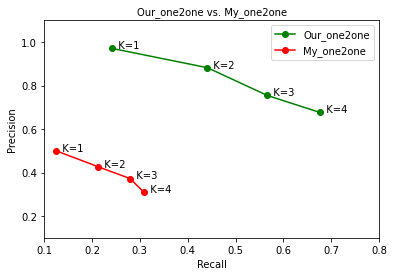

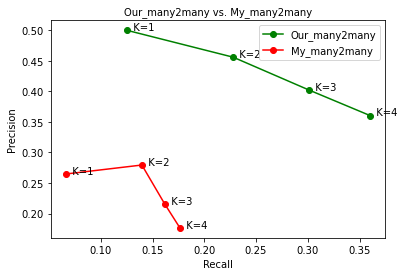

In [16]:
# one2one plot
k = [i for i in range(1, 5)]
plt.figure()
x1 = our_r_one
x2 = my_r_one
y1 = our_p_one
y2 = my_p_one
plt.title('Our_one2one vs. My_one2one', fontsize=10)
plt.xlim(0.1,0.8)
plt.ylim(0.1,1.1)
plt.plot(x1, y1, "-go", label='Our_one2one')
plt.plot(x2, y2, "-ro", label='My_one2one')
plt.ylabel('Precision', fontsize=10)
plt.xlabel('Recall', fontsize=10)
for i in range(4):
    plt.annotate('  K={}'.format(i + 1), xy = (our_r_one[i], our_p_one[i]), textcoords = 'data')
    plt.annotate('  K={}'.format(i + 1), xy = (my_r_one[i], my_p_one[i]), textcoords = 'data')
plt.legend(['Our_one2one', 'My_one2one'], loc='upper right') 
plt.savefig("imgPath/one2one.jpg")
plt.show()

# many2many plot
k = [i for i in range(1, 5)]
plt.figure()
x1 = our_r_many
x2 = my_r_many
y1 = our_p_many
y2 = my_p_many
plt.title('Our_many2many vs. My_many2many', fontsize=10)
plt.plot(x1, y1, "-go", label='Our_many2many')
plt.plot(x2, y2, "-ro", label='My_many2many')
plt.ylabel('Precision', fontsize=10)
plt.xlabel('Recall', fontsize=10)
for i in range(4):
    plt.annotate('  K={}'.format(i + 1), xy = (our_r_many[i], our_p_many[i]), textcoords = 'data')
    plt.annotate('  K={}'.format(i + 1), xy = (my_r_many[i], my_p_many[i]), textcoords = 'data')
plt.legend(['Our_many2many', 'My_many2many'], loc='upper right') 
plt.savefig("imgPath/many2many.jpg")
plt.show()